In [2]:
#imports
import random
import time
import networkx as nx
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
#methods for defining datasets
def big_square_tuples_list(n):
    
    tuples = []
    for i in range (n):
        a = random.randrange(0, 1000)
        b = random.randrange(0, 1000)
        tuples.append((a,b))
        
    return tuples
    
def random_tuple_groups_list(nodes, groups):
    
    tuples = []
    for j in range(0,groups):
        for i in range(int(nodes/groups)):
            a = random.randrange(j*groups*100 -350,j*groups*100)
            b = random.randrange(j*groups*100 -350,j*groups*100)
            tuples.append((a,b))
            
    return tuples
            
def circle_in_circle_tuples_list(nodes):
    tuples = []
    
    X, Y = datasets.make_circles(
    n_samples=nodes, factor=0.5, noise=0.05, random_state=30
    )
    
    
    for x in X:
        x[0] = x[0]*657
        x[1] = x[1]*657
        tuples.append((x[0],x[1]))
    return tuples

def double_horseshoes_tuples_list(nodes):
    tuples = []
    
    X,Y = datasets.make_moons(
    n_samples=nodes, noise=0.05, random_state=30
    )
    
    for x in X:
        x[0] = x[0]*750
        x[1] = x[1]*750
        tuples.append((x[0],x[1]))
        
    return tuples
        
    
def lines_tuples_list(nodes):
    points = []
    
    for i in range(0,nodes,10):
        points.append((i,i))
        points.append((i+100,i-100))
        points.append((i+200, i-200))
        points.append((i+300, i-300))
        points.append((i+400, i-400))
        
    return points



In [4]:
#methods used by spectral clustering method
def findNeighbors(graph, new_Node):
    neighbors = []
    for node in graph.nodes():
        distance = np.sqrt(np.square(new_Node[0] - node[0]) + np.square(new_Node[1] - node[1]))
        if distance < 50 and distance != 0:
            neighbors.append(node)
    return neighbors

def buildNeighborhood(graph, node,  visited):
    neighbors = findNeighbors(graph, node)
    if len(neighbors) > 3:
        for neighbor in neighbors:
            if (node,neighbor) not in graph.edges():
                graph.add_edge(node, neighbor)
    visited[node] = 1

def connectByProximity(graph,bag):
    #add all nodes to a bag
    for node in graph.nodes():
        bag.add(node)
    #mark all nodes unvisited
    visited = {node:0 for node in graph.nodes() }
    
    while len(bag.items) > 0:
        #remove node from bag
        new_Node= bag.get()
        if visited[new_Node] == 0:
            #mark node as visited
            visited[new_Node] = 1
            
            #search list of nodes for nodes within given radius
            neighbors = findNeighbors(graph, new_Node)
                #if neighbor count is high enough:
            if len(neighbors) > 0:
                #make new edges connecting node to neighbors
                for node in neighbors:
                    graph.add_edge(new_Node,node)
                    buildNeighborhood(graph, node, visited) 
                    
    return graph

def getAdjacencyMatrix(graph, bag):
    graph = connectByProximity(graph, bag)
    matrix = nx.to_numpy_array(graph)
    return(matrix)

class myQueue():
    
    def __init__(self):
        self.items = []
        
    def get(self):
        return self.items.pop(0)
    
    def add(self, item):
        self.items.append(item)

In [5]:
#code for k_means method for final step of spectral clustering

def init_centroids(k, data):
    centroids = []
    i = 0
    while i < k:
        centroid = random.choice(data)
        centroids.append(centroid)
        i+=1
    return centroids

def distance(X, Y):
    #X and Y are both arrays
    dist = np.square(np.sum((X-Y)**2))
    return dist

def get_dist(pair):
    return pair[0]

def mean_tuple(tuple_list):
    
    avg_x = sum(map(lambda x: x[0], tuple_list)) / len(tuple_list)
    avg_y = sum(map(lambda x: x[1], tuple_list)) / len(tuple_list)
    res = (avg_x, avg_y)
    return res
    
def create_cluster_lists(k):
    i = 0
    clustersclusters = []
    while i < k:
        cluster = []
        clustersclusters.append(cluster)
        i += 1
    return clustersclusters

def random_list_of_points_generator(n_tuples, val_limit):
    our_list = []
    for x in range(n_tuples):
        r1 = random.randint(1,val_limit)
        r2 = random.randint(1,val_limit)
        point = (r1, r2)
        our_list.append(point)
    return our_list

def visualize_clusters(c_lists):
    
    x = [None]*len(c_lists)
    y = [None]*len(c_lists)
    
    for i in range(len(c_lists)):
        
        xv = []
        yv = []
        
        for j in range(len(c_lists[i])):     
            
            xv.append(c_lists[i][j][0])
            yv.append(c_lists[i][j][1])
            
        x[i] = xv
        y[i] = yv
        
        plt.scatter(xv,yv)
    
    plt.show()
    
    #print(x)
    return x

def k_means_v1(point_list, k):
    #need to randomly assign he centroids at the beginning
    #out point_list is like [(x1,y1), (x2,y2), ... (xn,yn)]
    centroids = []
    centroids += random.sample(point_list, k)
    
    #ok i have some centroids now
    #we need to make a list called assignments for assigned cluster for each point
    #each index represents the same index point in point_list i.e. [...(x4,y4)...] will have assignment at asn[3].
    lst = [None]*(len(point_list))
    
    #i think here is where we do a while loop a couple times to assign/reassign clusters and centroids so... here goes
    iterations = 0
    start_time = time.time()
    while iterations < 10:

        #kk that list is now a thing
        #use euclidean distance to calculate distance from each point to each centroid
        for i in range(len(point_list)):
            point = point_list[i]
            point_dists = []
            label = 0
            
            for centroid in centroids:

                a = point[0]-centroid[0]
                b = point[1]-centroid[1]
                sum = a**2 + b**2
                dist = math.sqrt(sum)
                point_dists.append((dist, label))
                label += 1

            sorted_by_distance = sorted(point_dists, key = get_dist)
            #now we have a list of length k where the shortest distance is at the 0th index, with label of k closest centroid
            #need to assign the point to the appropriate centroid in lst
            lst[i] = sorted_by_distance[0][1]
        #cool so all of the points are now assigned to an initial cluster
        #now we need to calculate the mean distance between all the points in our clusters and update the centroid to be that new point
        #keep doing all this a certain number of times for now (eventually until the distance between old_c and new_c becomes very small i.e. convergent)
        cluster_lists = create_cluster_lists(k)
        lmao = k
        lamo = 0
        #need a loopdeeloop to assign points to their clusters for mean analysis based on lst value of index
        for i in lst:
            cluster_lists[i].append(point_list[lamo])
            lamo += 1

        if iterations == 9:
            visualize_clusters(cluster_lists)
            
        for x in range(k):
            centroids[x] = mean_tuple(cluster_lists[x])

        #print(centroids)
        iterations += 1
    
    
    clusters = {point:0 for point in point_list}
    for i in range(len(cluster_lists)):
        for point in cluster_lists[i]:
            clusters[point] = i
    
    return clusters

In [6]:
def spectralClustering(graph, k):
    
    #get adjacency matrix for graph
    Amatrix = getAdjacencyMatrix(graph, myQueue())
    n, m = Amatrix.shape

    #make Laplacian Matrix
    Dmatrix = np.diag(Amatrix.sum(axis=1))
    Lmatrix = Dmatrix - Amatrix

    #get the eigenvalues and eigenvectors
    eigvals, eigvects = np.linalg.eig(Lmatrix)
    eigvals = np.real(eigvals)
    eigvects = np.real(eigvects)
    
 
    #take second and third eigenvector for two clusters
    feature_matrix = eigvects[:,:2]
   
    y= []
    for i in range(len(graph.nodes())):
            y.append((feature_matrix[i,0],feature_matrix[i,1]))
    
    #take decomposition of eigenvectors and assign to each node in graph
    decomp = {node:0 for node in graph.nodes()}
    nodes = list(graph.nodes())
    for i in range(len(graph.nodes())):
        decomp[nodes[i]] = y[i]     
        
    
    #cluster points based on decomposition of eigenvector using k means
    clusters = k_means_v1(y, k)

                   
    #take clusters dictionary and assign to nodes dictionary
    for node in decomp:
        decomp[node] = clusters[decomp[node]]
        
    

    nx.draw_networkx(gr, {node:node for node in gr.nodes()}, 
                 node_color = [decomp[node] for node in gr.nodes()],
                 with_labels = False, 
                 node_size = 5)
    
    return decomp

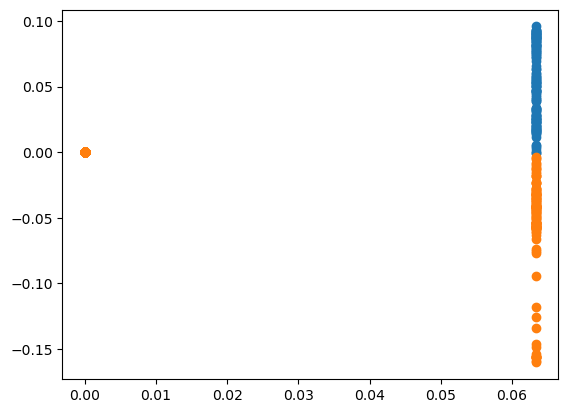

Runtime:
5.009170055389404


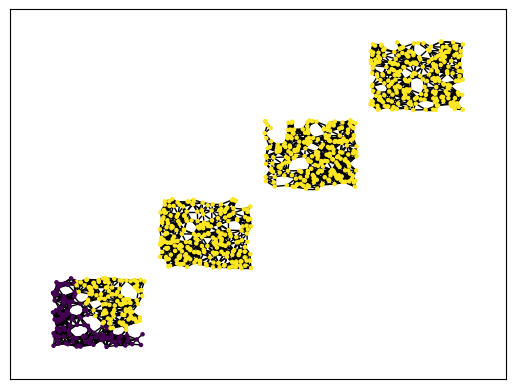

In [22]:
#runtime test for boxes plot
tupleList = random_tuple_groups_list(1000,4)
gr = nx.Graph()
gr.add_nodes_from(tupleList)


startTime = time.time()
spectralClustering(gr, 2)
endTime = time.time()

runTime = endTime - startTime
print("Runtime:")
print(runTime)

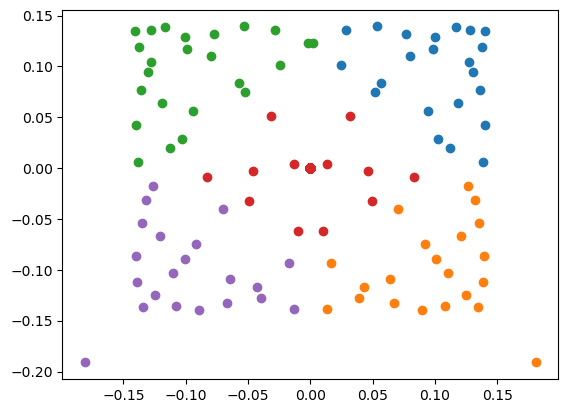

Runtime:
1.4511120319366455


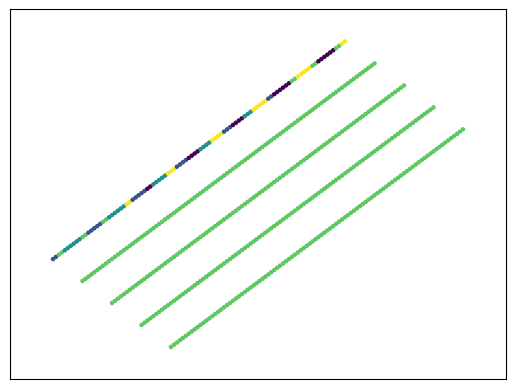

In [8]:
#runtime test for lines plot
tupleList = lines_tuples_list(1000)
gr = nx.Graph()
gr.add_nodes_from(tupleList)


startTime = time.time()
spectralClustering(gr, 5)
endTime = time.time()

runTime = endTime - startTime
print("Runtime:")
print(runTime)

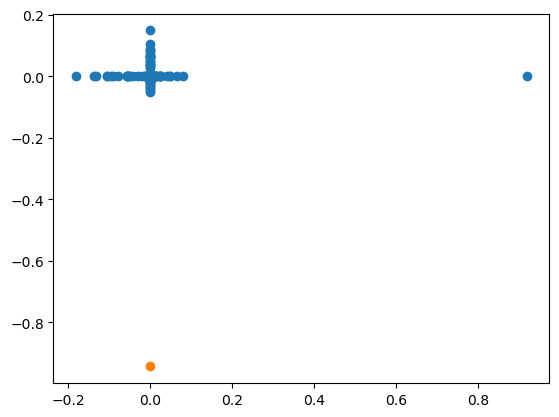

Runtime:
4.788370132446289


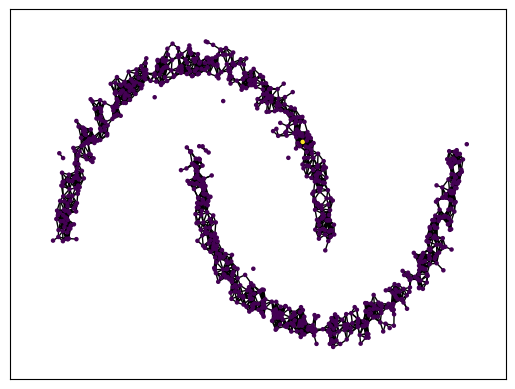

In [334]:
#runtime test for horseshoes plot
tupleList = double_horseshoes_tuples_list(1000)
gr = nx.Graph()
gr.add_nodes_from(tupleList)


startTime = time.time()
spectralClustering(gr, 2)
endTime = time.time()

runTime = endTime - startTime
print("Runtime:")
print(runTime)

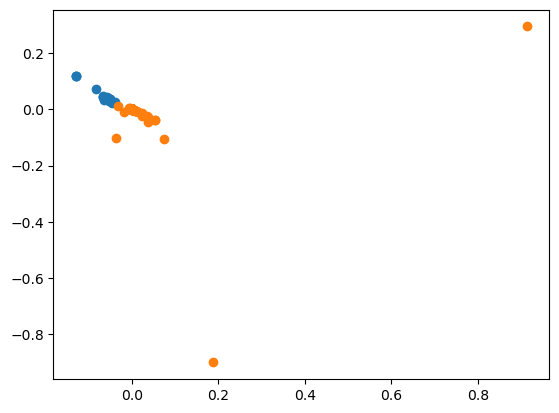

Runtime:
4.932599067687988


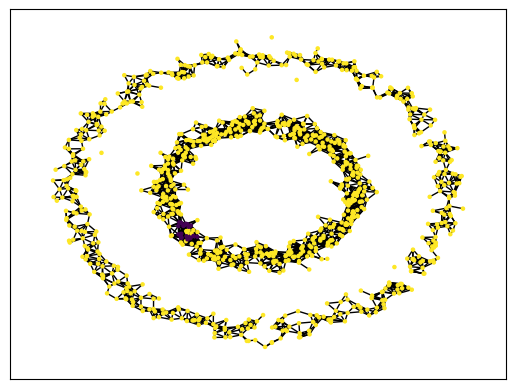

In [331]:
#runtime test for circles plot
tupleList = circle_in_circle_tuples_list(1000)
gr = nx.Graph()
gr.add_nodes_from(tupleList)


startTime = time.time()
spectralClustering(gr, 2)
endTime = time.time()

runTime = endTime - startTime
print("Runtime:")
print(runTime)


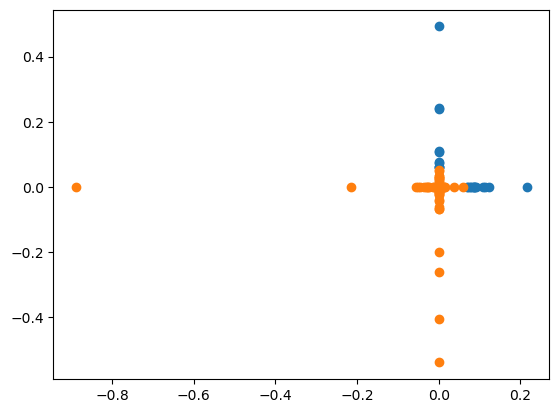

Runtime:
5.372285842895508


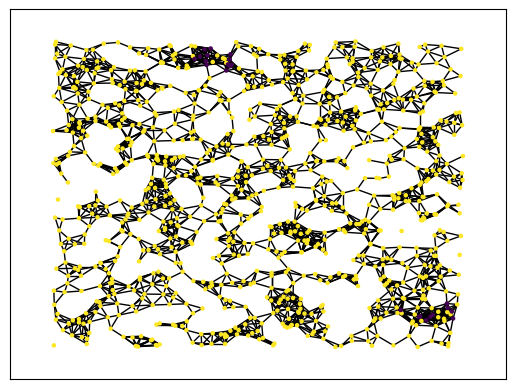

In [332]:
#runtime test for large square plot
tupleList = big_square_tuples_list(1000)
gr = nx.Graph()
gr.add_nodes_from(tupleList)


startTime = time.time()
spectralClustering(gr, 2)
endTime = time.time()

runTime = endTime - startTime
print("Runtime:")
print(runTime)